In [49]:
import math
import random
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score,r2_score,mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.utils.class_weight
from sklearn import svm,tree
from sklearn import linear_model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
import seaborn as sns
from tabulate import tabulate

In [45]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("c_matrix.jpg")
    return ax

Prepare the dataset


In [51]:
dataset=pd.read_csv("train_set.tsv",sep='\t',header=0)

#print(dataset["num_collisions"].value_counts(normalize=False))

X=dataset.iloc[:,:-2]  # : all raws :-2 slice out the last 2 columns
y=dataset.iloc[:,-2]   #just the last column

#normalized_df=(dataset-dataset.mean())/dataset.std()
Stdscaler = preprocessing.StandardScaler().fit(X)
X= Stdscaler.transform(X)
#X=(X-X.min())/(X.max()-X.min())  #between 0 and 1 (is column-wise)
#print(X.describe)
#print(X.std())
random_state=10
d={
   2:80,
   3:30,
   4:10
}
smote=SMOTE(sampling_strategy=d,k_neighbors=1)
#smote=SMOTEENN(smote=smote)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state) #to be reproducible
X_train,y_train=smote.fit_resample(X_train,y_train)
print("train-set composition: ",y_train.value_counts(normalize=False))
print("test-set composition: ",y_test.value_counts(normalize=False))
print("dataset composition: ",y.value_counts(normalize=False))

#create data
data = [["class 0", 538], 
        ["class 1", 333], 
        ["class 2", 96], 
        ["class 3", 30],
        ["class 4",3]
        ]
  
#define header names
col_names = ["class", "composition"]
  
#display table
print(tabulate(data, headers=col_names))



print("Number of training samples: %d" %(X_train.shape[0]))
print("Number of test samples: %d" %(X_test.shape[0]))


train-set composition:  0    434
1    263
2     80
3     30
4     10
Name: num_collisions, dtype: int64
test-set composition:  0    104
1     70
2     22
3      3
4      1
Name: num_collisions, dtype: int64
dataset composition:  0    538
1    333
2     96
3     30
4      3
Name: num_collisions, dtype: int64
class      composition
-------  -------------
class 0            538
class 1            333
class 2             96
class 3             30
class 4              3
Number of training samples: 817
Number of test samples: 200


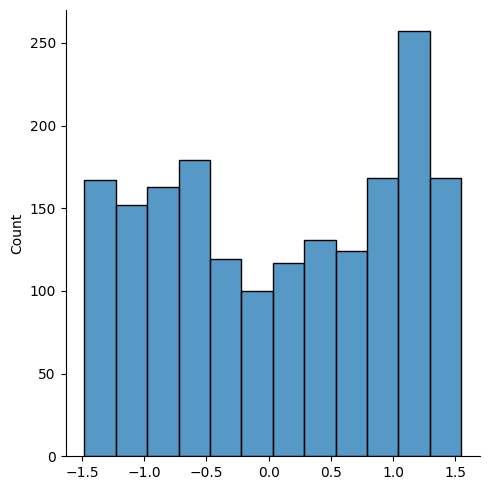

In [149]:
sns.displot(X[:,4])

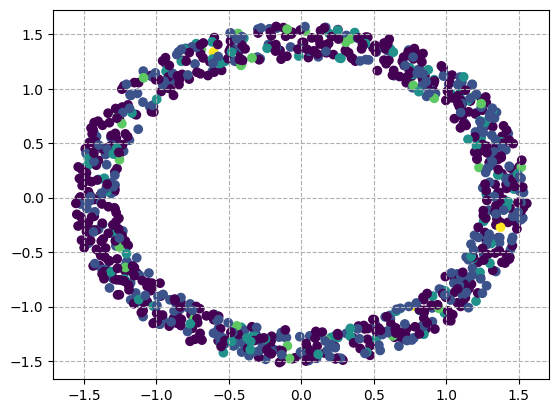

In [28]:
# select the first two features
X_reduced = X[:,3:5]
#no lineary separable in 2D with only 2 features

plt.figure()
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y)
plt.grid(linestyle="--")

GaussianNB

Input shape reduced train: (427, 2)
Input shape reduced test: (183, 2)


Text(0.5, 1.0, 'Training and test samples')

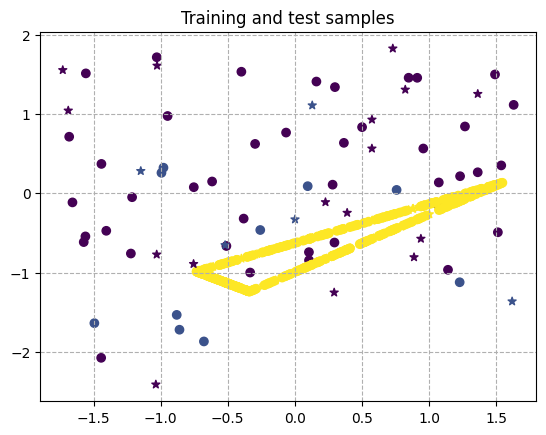

In [162]:
# select the first two features
X_train_reduced = X_train[:,0:2]
X_test_reduced = X_test[:,0:2]
print("Input shape reduced train: %s" %str(X_train_reduced.shape))
print("Input shape reduced test: %s" %str(X_test_reduced.shape))

plt.figure()
plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1], c=y_train)
plt.scatter(X_test_reduced[:,0], X_test_reduced[:,1], c=y_test, marker="*")
plt.grid(linestyle="--")
plt.title("Training and test samples")

In [163]:
gen_model = GaussianNB()
gen_model.fit(X_train_reduced, y_train)
y_pred = gen_model.predict(X_test_reduced)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)


Accuracy 0.929


Accuracy 0.540
[0.67375887 0.2826087  0.         0.         0.        ]


[Text(0.4230769230769231, 0.875, 'X[3] <= -1.232\ngini = 0.612\nsamples = 827\nvalue = [434, 263, 80, 40, 10]'),
 Text(0.15384615384615385, 0.625, 'X[14] <= -1.57\ngini = 0.485\nsamples = 137\nvalue = [93, 30, 10, 4, 0]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0, 0, 0]'),
 Text(0.23076923076923078, 0.375, 'X[30] <= -1.635\ngini = 0.466\nsamples = 133\nvalue = [93, 26, 10, 4, 0]'),
 Text(0.15384615384615385, 0.125, 'gini = 0.5\nsamples = 6\nvalue = [1, 4, 1, 0, 0]'),
 Text(0.3076923076923077, 0.125, 'gini = 0.439\nsamples = 127\nvalue = [92, 22, 9, 4, 0]'),
 Text(0.6923076923076923, 0.625, 'X[4] <= 1.241\ngini = 0.629\nsamples = 690\nvalue = [341, 233, 70, 36, 10]'),
 Text(0.5384615384615384, 0.375, 'X[22] <= 1.211\ngini = 0.631\nsamples = 557\nvalue = [261, 206, 55, 26, 9]'),
 Text(0.46153846153846156, 0.125, 'gini = 0.614\nsamples = 469\nvalue = [233, 168, 47, 12, 9]'),
 Text(0.6153846153846154, 0.125, 'gini = 0.679\nsamples = 88\nvalue = [28, 38, 

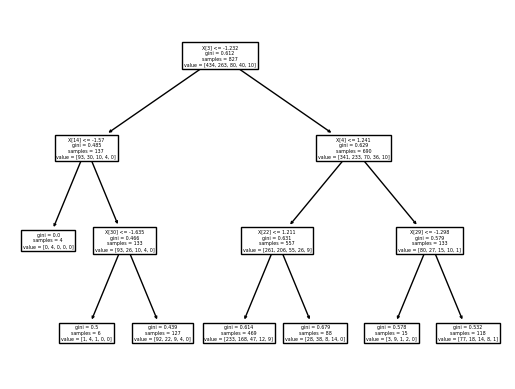

In [31]:
classifier=DecisionTreeClassifier(max_depth=3)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))
tree.plot_tree(classifier)


Accuracy 0.400
[0.49       0.36477987 0.11428571 0.         0.        ]
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       104
           1       0.33      0.41      0.36        70
           2       0.15      0.09      0.11        22
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1

    accuracy                           0.40       200
   macro avg       0.20      0.20      0.19       200
weighted avg       0.40      0.40      0.40       200



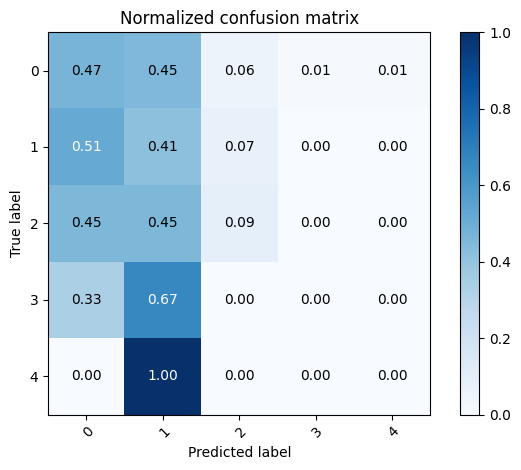

In [44]:
#classifier=svm.SVC(C=1,kernel='rbf',gamma=0.057,class_weight='balanced')
classifier=svm.SVC(C=1.3,kernel='poly',degree=3,gamma=0.02857142857142857,class_weight='balanced')
#classifier=svm.SVC(C=1,kernel='poly',degree=4,gamma='scale',class_weight='balanced')
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))
plot_confusion_matrix(y_test, y_pred,np.array([0,1,2,3,4]),normalize=True)
print(classification_report(y_test, y_pred))


In [40]:
classifier=svm.SVC()

pargrid={
    "kernel":["poly"],
    "degree":[2,3,4,5],
    "gamma":[1/35, 1/70, 2/35, 5/35, 0.5, 0.75, 1],
    "C":[0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.3, 1.7]
    }

gs = GridSearchCV(classifier, pargrid, scoring="f1_micro", n_jobs=-1, refit=True, verbose=3) 
gs.fit(X_train, y_train)

print(f"Best parameters found:\n{gs.best_params_}")

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[CV 1/5] END C=0.1, degree=2, gamma=0.02857142857142857, kernel=poly;, score=0.530 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.02857142857142857, kernel=poly;, score=0.530 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.02857142857142857, kernel=poly;, score=0.534 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.014285714285714285, kernel=poly;, score=0.530 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.02857142857142857, kernel=poly;, score=0.534 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.014285714285714285, kernel=poly;, score=0.534 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.014285714285714285, kernel=poly;, score=0.534 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.014285714285714285, kernel=poly;, score=0.528 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.014285714285714285, kernel=poly;, score=0.530 total time=   0.0s
[CV 5/5] END 

Ensemble of kernelized methods and simple methods with BOOSTING (trying to improve Aaccuracy)


In [21]:
classifier_name = 'S'
algorithm = 'SAMME' 
n_estimators=np.random.randint(5, 70, 5)

all_classifiers = {
    'G': [GaussianNB, 'Gaussian Naive Bayes'],
    'P': [Perceptron(), 'Perceptron'],
    'LR': [LogisticRegression, 'Logistic Regression'],
    'D': [DecisionTreeClassifier, 'Decision Tree'],
    'S': [svm.SVC, 'SVM']     
    }

#print(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=y))

boosting_params = {
  'learning_rate': np.random.uniform(size=5),
  'n_estimators': n_estimators,
  }

Accuracy on train_set: 0.531 Accuracy on test_set: 0.520
f1-score:  [0.68421053 0.         0.         0.         0.        ]
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       104
           1       0.00      0.00      0.00        70
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1

    accuracy                           0.52       200
   macro avg       0.10      0.20      0.14       200
weighted avg       0.27      0.52      0.36       200



/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mf/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

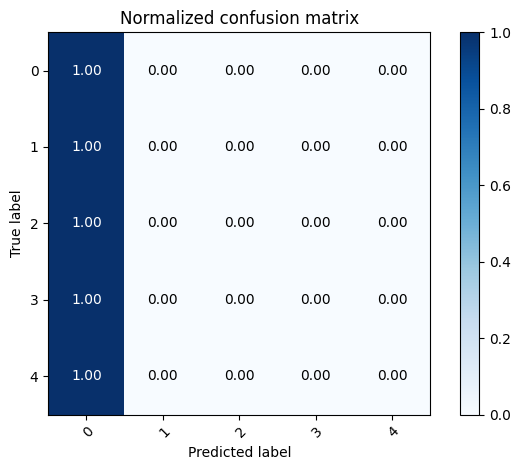

In [20]:

adaboost_classifier = AdaBoostClassifier(
    base_estimator=all_classifiers['S'][0](C=0.5,kernel='poly',degree=2,gamma='scale'),    
    n_estimators=17, 
    learning_rate=0.2, 
    algorithm= algorithm, 
    random_state=random_state
    ).fit(X_train, y_train)

y_pred=adaboost_classifier.predict(X_test)
ada_accuracy_train = adaboost_classifier.score(X_train, y_train)  
ada_accuracy_test = adaboost_classifier.score(X_test,y_test)
print("Accuracy on train_set: %.3f" %ada_accuracy_train,"Accuracy on test_set: %.3f" %ada_accuracy_test)
print("f1-score: ",sklearn.metrics.f1_score(y_test, y_pred,average=None))
print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred,np.array([0,1,2,3,4]),normalize=True)

In [19]:
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
#print(sklearn.metrics.get_scorer_names())
grid_search_boosting = GridSearchCV(
    adaboost_classifier,
    boosting_params, 
    scoring='f1_weighted',   #accuracy,f1_micro,f1_macro,balanced_accuracy,f1_weighted
    cv=cv, 
    return_train_score=False,
    verbose=0,
    
)
grid_search_boosting.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for boosting classifier: %r" %grid_search_boosting.best_params_)
print("Best accuracy: %.4f" %grid_search_boosting.best_score_)
print("Boosting Accuracy over the test set: %.4f" %grid_search_boosting.score(X_test, y_test))

Best classification hyper-parameters for boosting classifier: {'learning_rate': 0.17604398166378, 'n_estimators': 27}
Best accuracy: 0.3697
Boosting Accuracy over the test set: 0.3558


Bagging

Accuracy on train_set: 0.662 Accuracy on test_set: 0.500
[0.6446281  0.30909091 0.21052632 0.28571429 0.        ]


<AxesSubplot: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

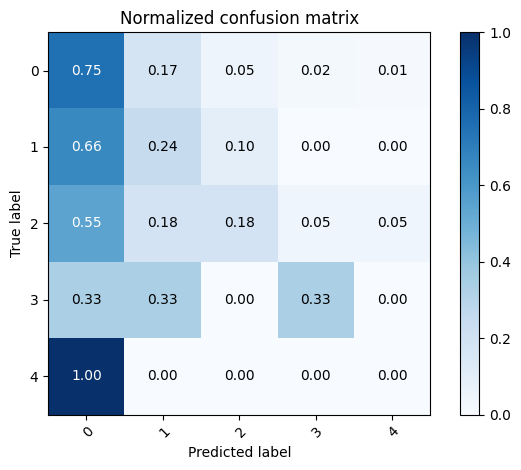

In [48]:
bagging_params = {
  'max_samples': np.random.randint(5,int(len(X_train)/2), 5),
  'n_estimators': n_estimators,
}
bagging_classifier = BaggingClassifier(
    base_estimator=all_classifiers[classifier_name][0](C=0.5,kernel='poly',degree=2,gamma='scale',class_weight='balanced'), 
    max_samples=340, 
    n_estimators=55,  
    random_state=random_state,
    ).fit(X_train, y_train)

y_pred=bagging_classifier.predict(X_test)
bagging_accuracy_test = bagging_classifier.score(X_test, y_test)
bagging_accuracy_train = bagging_classifier.score(X_train, y_train)  
print("Accuracy on train_set: %.3f" %bagging_accuracy_train,"Accuracy on test_set: %.3f" %bagging_accuracy_test)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))
plot_confusion_matrix(y_test, y_pred,np.array([0,1,2,3,4]),normalize=True)



In [31]:
grid_search_bagging = GridSearchCV(
    bagging_classifier,
    bagging_params, 
    scoring='f1_weighted', 
    cv=cv, 
    return_train_score=False,
    # change max_features
    verbose=0
)
grid_search_bagging.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for bagging classifier: %r" %grid_search_bagging.best_params_)
print("Best accuracy: %.4f" %grid_search_bagging.best_score_)
print("Bagging Accuracy over the test set: %.4f" %grid_search_bagging.score(X_test, y_test))

/home/mf/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/home/mf/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/mf/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 297, in fit
    return self._fit(X, y, self.max_samples, sample_weight=sample_weight)
  File "/home/mf/.local/lib/python3.8/site-packages/sklearn/ensemble/_bagging.py", line 434, in _fit
    all_results = Parallel(
  File

Best classification hyper-parameters for bagging classifier: {'max_samples': 346, 'n_estimators': 55}
Best accuracy: 0.4479
Bagging Accuracy over the test set: 0.4967


REGRESSION


In [22]:
X=dataset.iloc[:,:-2]
y_reg=dataset.iloc[:,-1] 
print(y_reg)
random_state=10
d={
   2:80,
   3:29,
   4:10
}

X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2,random_state=random_state) 

0       1673.734894
1      51230.547792
2      18668.177773
3      10159.624794
4      22110.623878
           ...     
995     5578.067976
996     6538.063543
997     4390.186841
998     1583.747305
999     6115.545330
Name: min_CPA, Length: 1000, dtype: float64


In [41]:
model_type = "poly_svm" 

if model_type == "linear_regression":
  model = linear_model.LinearRegression()
  model.fit(X_train, y_train)

elif model_type == "linear_svm":
  model = svm.SVR(kernel='linear', C=1.5)
  model.fit(X_train, y_train)

elif model_type == "poly_svm":
  model = svm.SVR(kernel='poly', C=1.9, degree=2, gamma='scale')
  model.fit(X_train, y_train)


In [42]:
y_pred = model.predict(X_test)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test,y_pred))

print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 133738447.75
Variance score: -0.06


In [40]:
grid_search_regression = GridSearchCV(model,
                           {
                              'C':np.arange(0.1,2,0.1),                            
                            'degree': np.arange(1,4,1),
                            },cv=5, scoring="r2",verbose=1,n_jobs=-1
                           )
print("\n\nGrid Search for Classification\n\n")
print(grid_search_regression.fit(X_train,y_train))
print(grid_search_regression.best_params_)



Grid Search for Classification


Fitting 5 folds for each of 57 candidates, totalling 285 fits
GridSearchCV(cv=5, estimator=SVR(C=1.5, degree=4, kernel='poly'), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
                         'degree': array([1, 2, 3])},
             scoring='r2', verbose=1)
{'C': 1.9000000000000001, 'degree': 2}
